# Predict on new data using a trained CNN on XPS data on Google Colab

In this notebook, we will use a trained convolutional network to predict on unseen XPS spectra.

## Setup

### Mount google drive, change working directory

In [ ]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [ ]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib
import matplotlib.pyplot as plt

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Check TensorFlow version

In [ ]:
tf.__version__

'2.6.0'

## Predict on new data set

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure

In [ ]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = 'test'

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = 'regression',
                            intensity_only = True)

Model folder created at /20210924_11h30m_test/model
Logs folder created at /20210924_11h30m_test/logs
Figures folder created at /20210924_11h30m_test/figures


### Load and inspect the data

Data was loaded!
Total no. of samples: 100
No. of training samples: 1
No. of validation samples: 0
No. of test samples: 99
Shape of each sample : 2921 features (X) + 7 labels (y)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


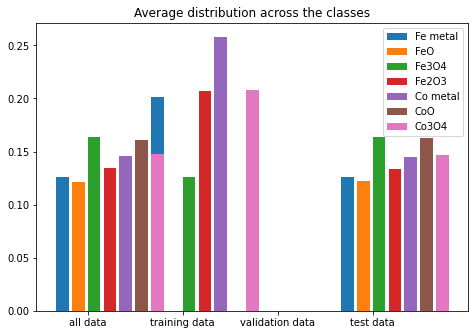

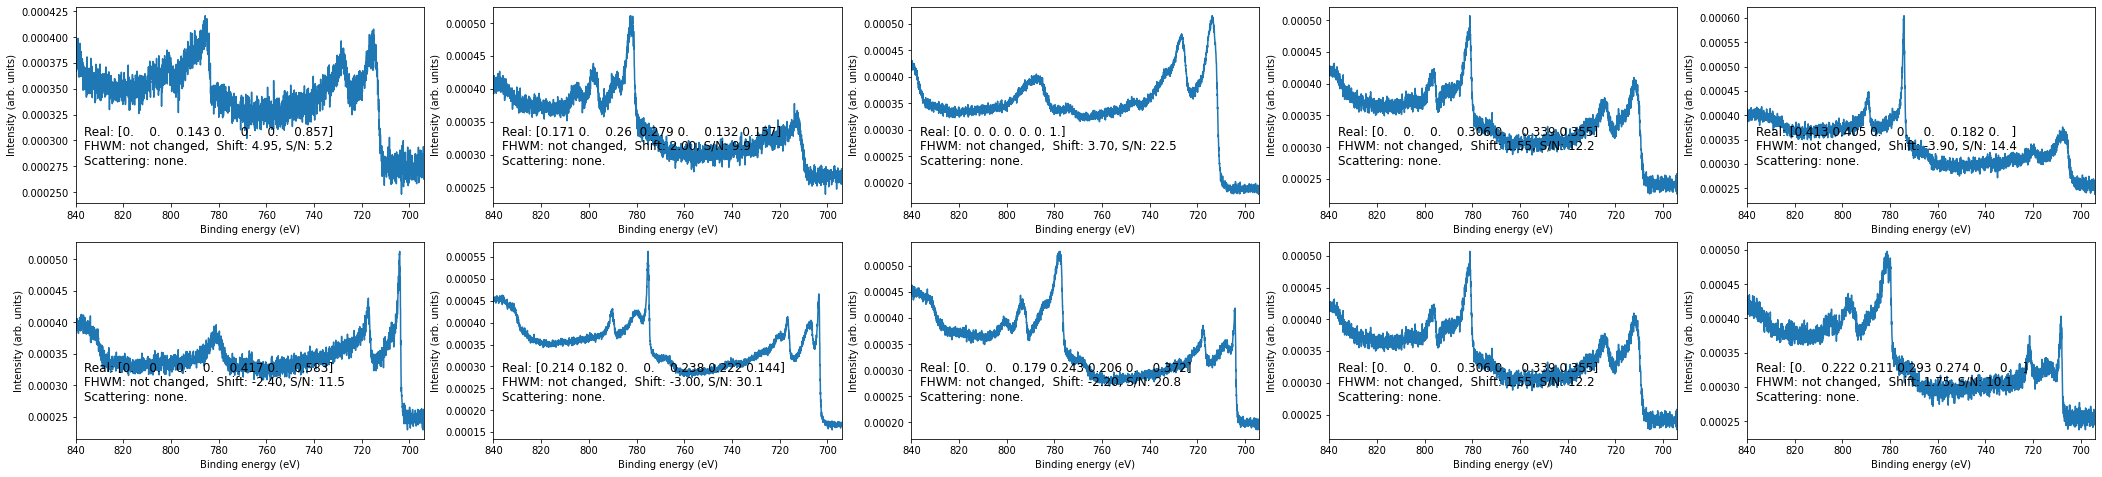

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210903_CoFe_combined_without_auger_peaks.h5'

train_test_split = 0.99
train_val_split = 0
no_of_examples = 100#000 #180

        
X_train, X_val, X_test, y_train, y_val, y_test,\
    names_train, names_val, names_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'test')  

### Continue with 10-point average of last values (cutoff: 5 eV on each side)

In [ ]:
for dataset in [clf.datahandler.X,
                clf.datahandler.X_train,
                clf.datahandler.X_val,
                clf.datahandler.X_test]:
    for arr in dataset:
        arr[:100,:] = np.average(arr[100:110,:],
                                 axis=0)
        arr[-100:,:] = np.average(arr[-110:-100,:],
                                  axis=0)

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test')  

### Load and compile the model

In [ ]:
clf.load_model(model_path = '/content/drive/My Drive/deepxps/runs/20210914_19h11m_FeCo_combined_without_auger_7_classes_no_window/model')

Loaded model from disk.


### Plot summary and save model plot.


Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2921, 1)]    0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1D)           (None, 2921, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1D)          (None, 2921, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1D)            (None, 2921, 12)     192         input_1[0][0]                    
_______________________________________________________________________________________

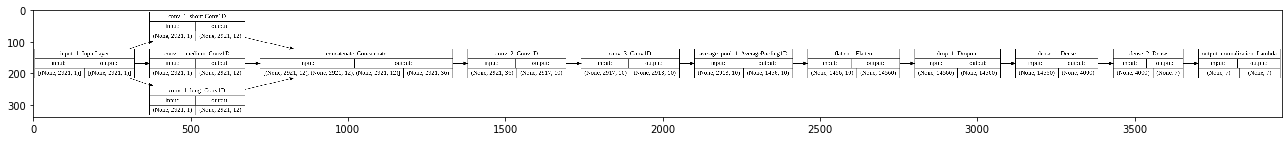

In [ ]:
clf.summary()
clf.save_and_print_model_image()

### Evaluate on test data

In [ ]:
clf.logging.hyperparams['batch_size'] = 32

if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

4/4 [==============================] - 30s 27ms/step - loss: 0.0239 - mse: 0.0020
Evaluation done! 

Test loss: [0.02393409 0.00198714]


###  Predict on train & test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

4/4 [==============================] - 0s 12ms/step
Prediction done!


### Show some predictions on random test samples

Calculating loss for each example...
Done!


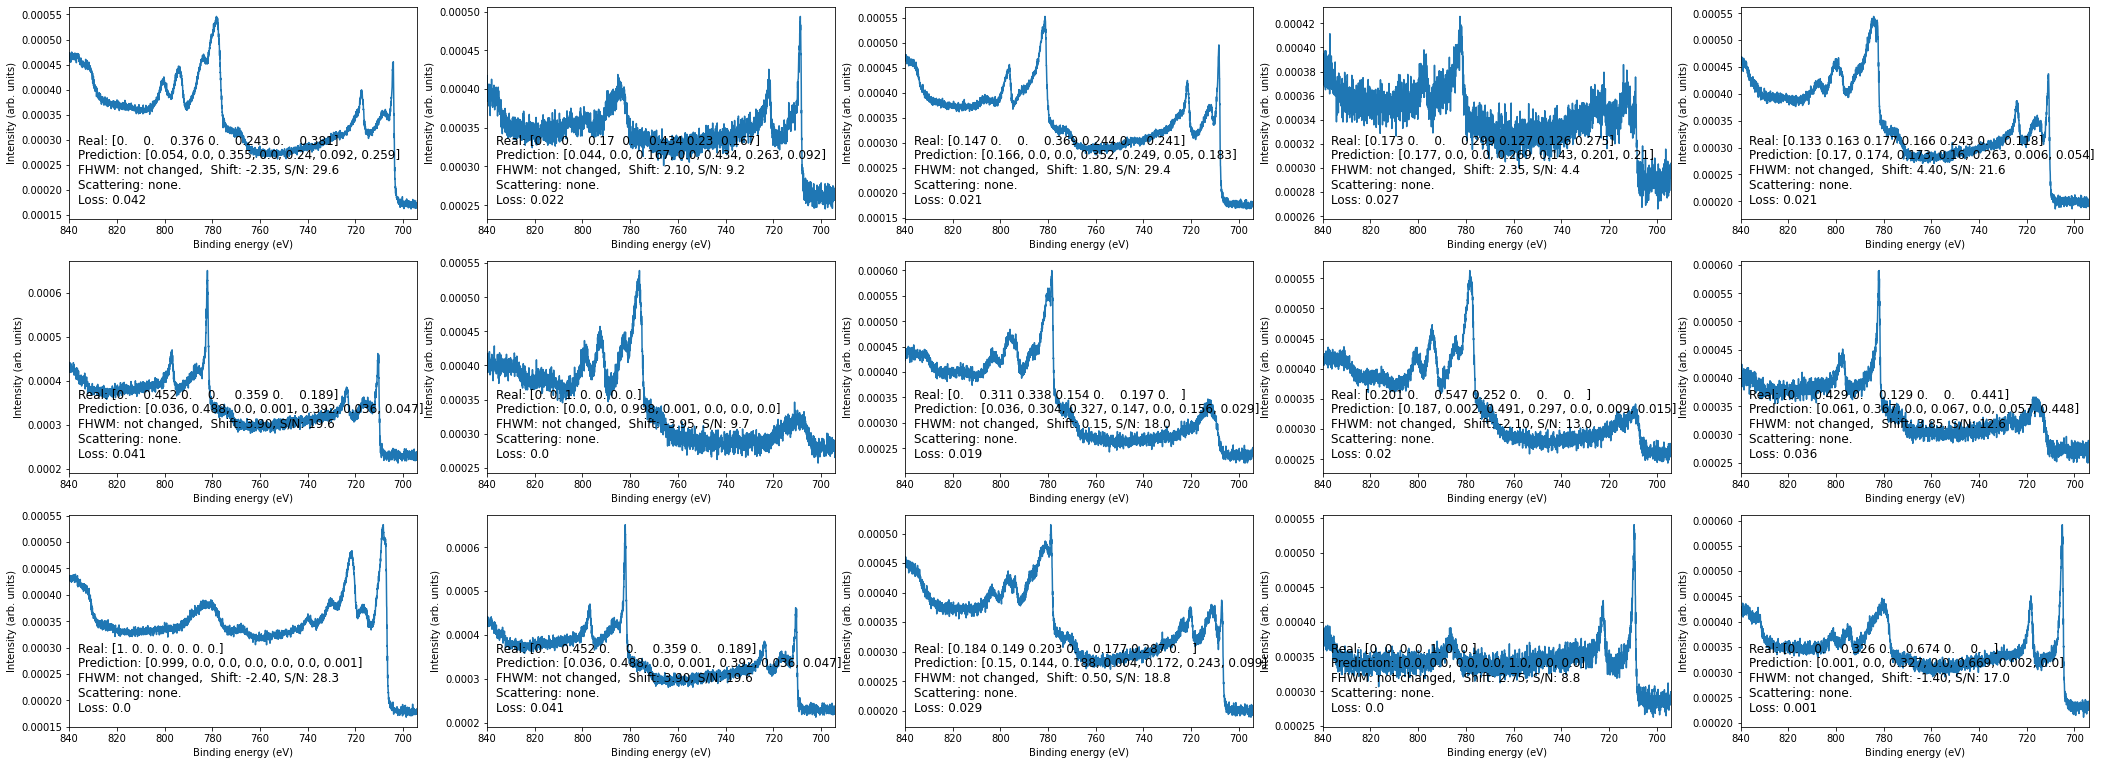

In [ ]:
clf.plot_random(no_of_spectra = 15, dataset = 'test', with_prediction = True)  

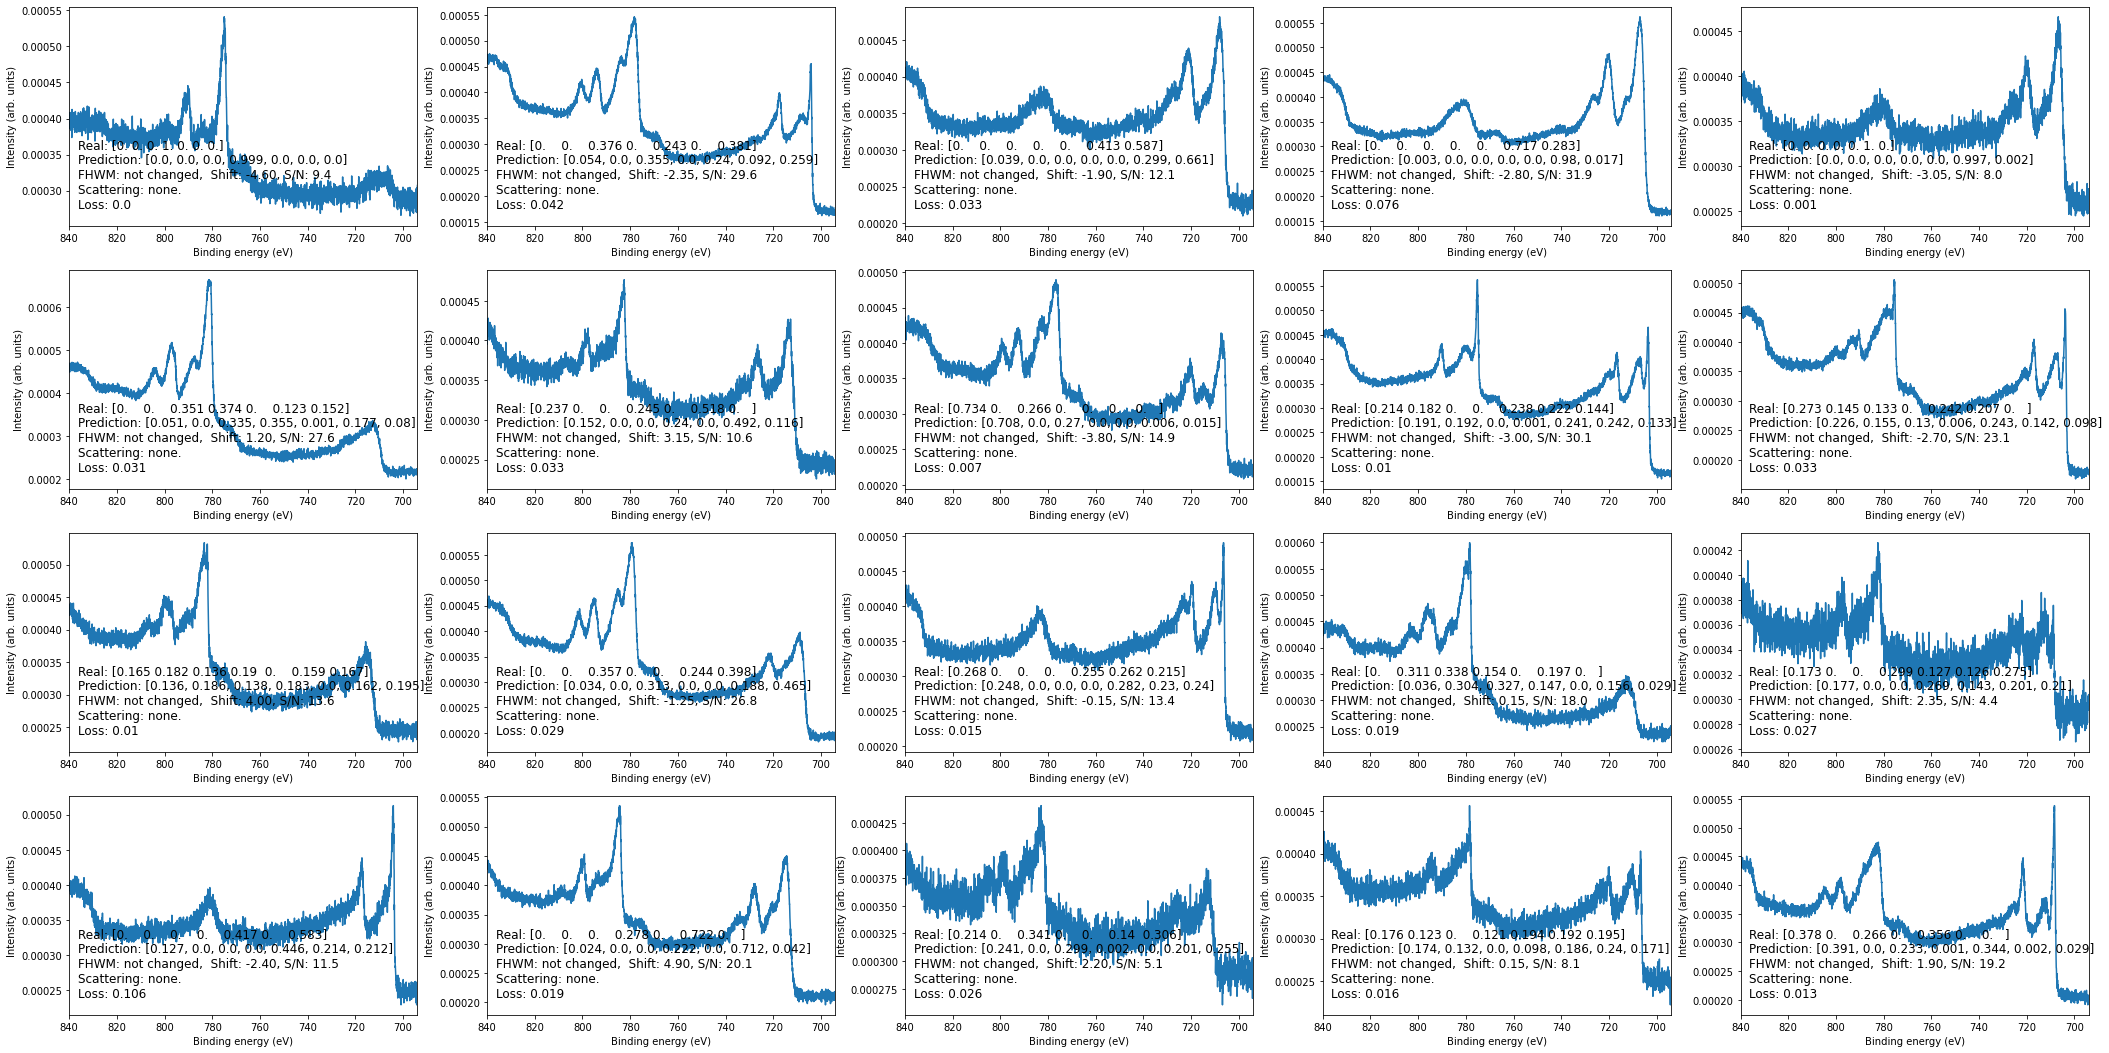

In [ ]:
clf.datahandler.plot_spectra(no_of_spectra=20, dataset="test", indices=list(range(20)), with_prediction=True)


### Show the worst predictions on the test samples

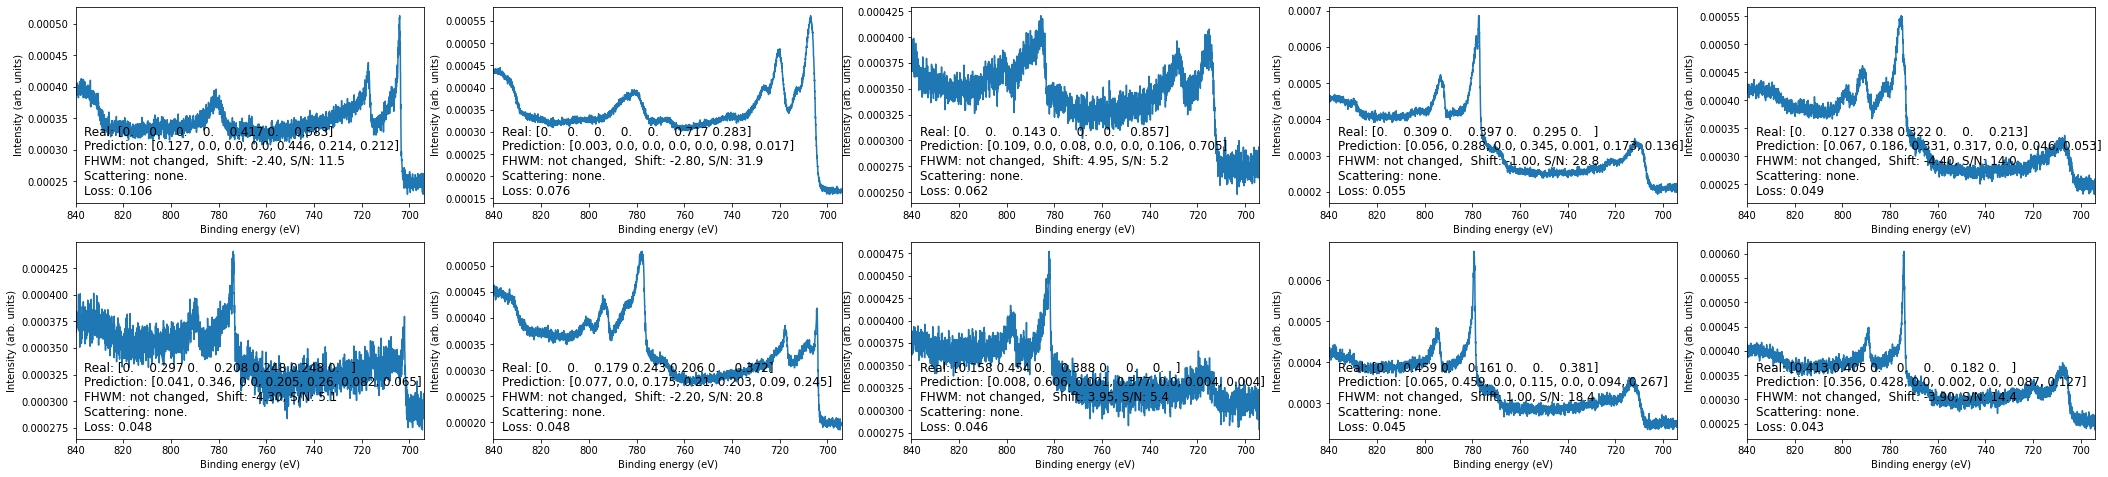

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10)

### Save data

In [ ]:
#clf.save_hyperparams()
clf.pickle_results()

Saved results to file.


## Check where and why the predictions fail

### Show worst predictions for single spectra

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10, kind = 'single')

#### Show worst predictions for different loss thresholds (single spectra)


In [ ]:
threshold = 0.2
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.1
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.05
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.02
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.01
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

### Show worst predictions for linearly combined spectra

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb')

#### Show worst predictions for different loss thresholds (linearly combined spectra)

In [ ]:
threshold = 0.3
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.2
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.1
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.05
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.025
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.01
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.005
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

### Show worst predictions for all

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all')

### Show worst predictions for different loss thresholds (all spectra)

In [ ]:
threshold = 0.3
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.2
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.1
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.05
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.025
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.01
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.005
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.001
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.0005
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.00025
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.0001
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.00001
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

## Remove empty model directory

In [ ]:
import shutil
shutil.rmtree(clf.logging.model_dir)

del(clf.logging.model_dir)

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/predict_unknown.ipynb'
output_file = os.path.join(clf.logging.log_dir,
                           'predict_unknown_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!


In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
from tensorflow.keras.models import load_model, Model,  model_from_json

def predict_probabilistic(model, data):   
    no_of_predictions = 1000
    prob_preds = np.array([model.predict(data["X"]) for i in range(no_of_predictions)]).transpose(1, 0, 2)
    
    return prob_preds

clf.load_model(model_path = '/content/drive/My Drive/deepxps/runs/20210914_19h11m_FeCo_combined_without_auger_7_classes_no_window/model')
prob_preds = predict_probabilistic(clf.model, original_data) 

Loaded model from disk.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

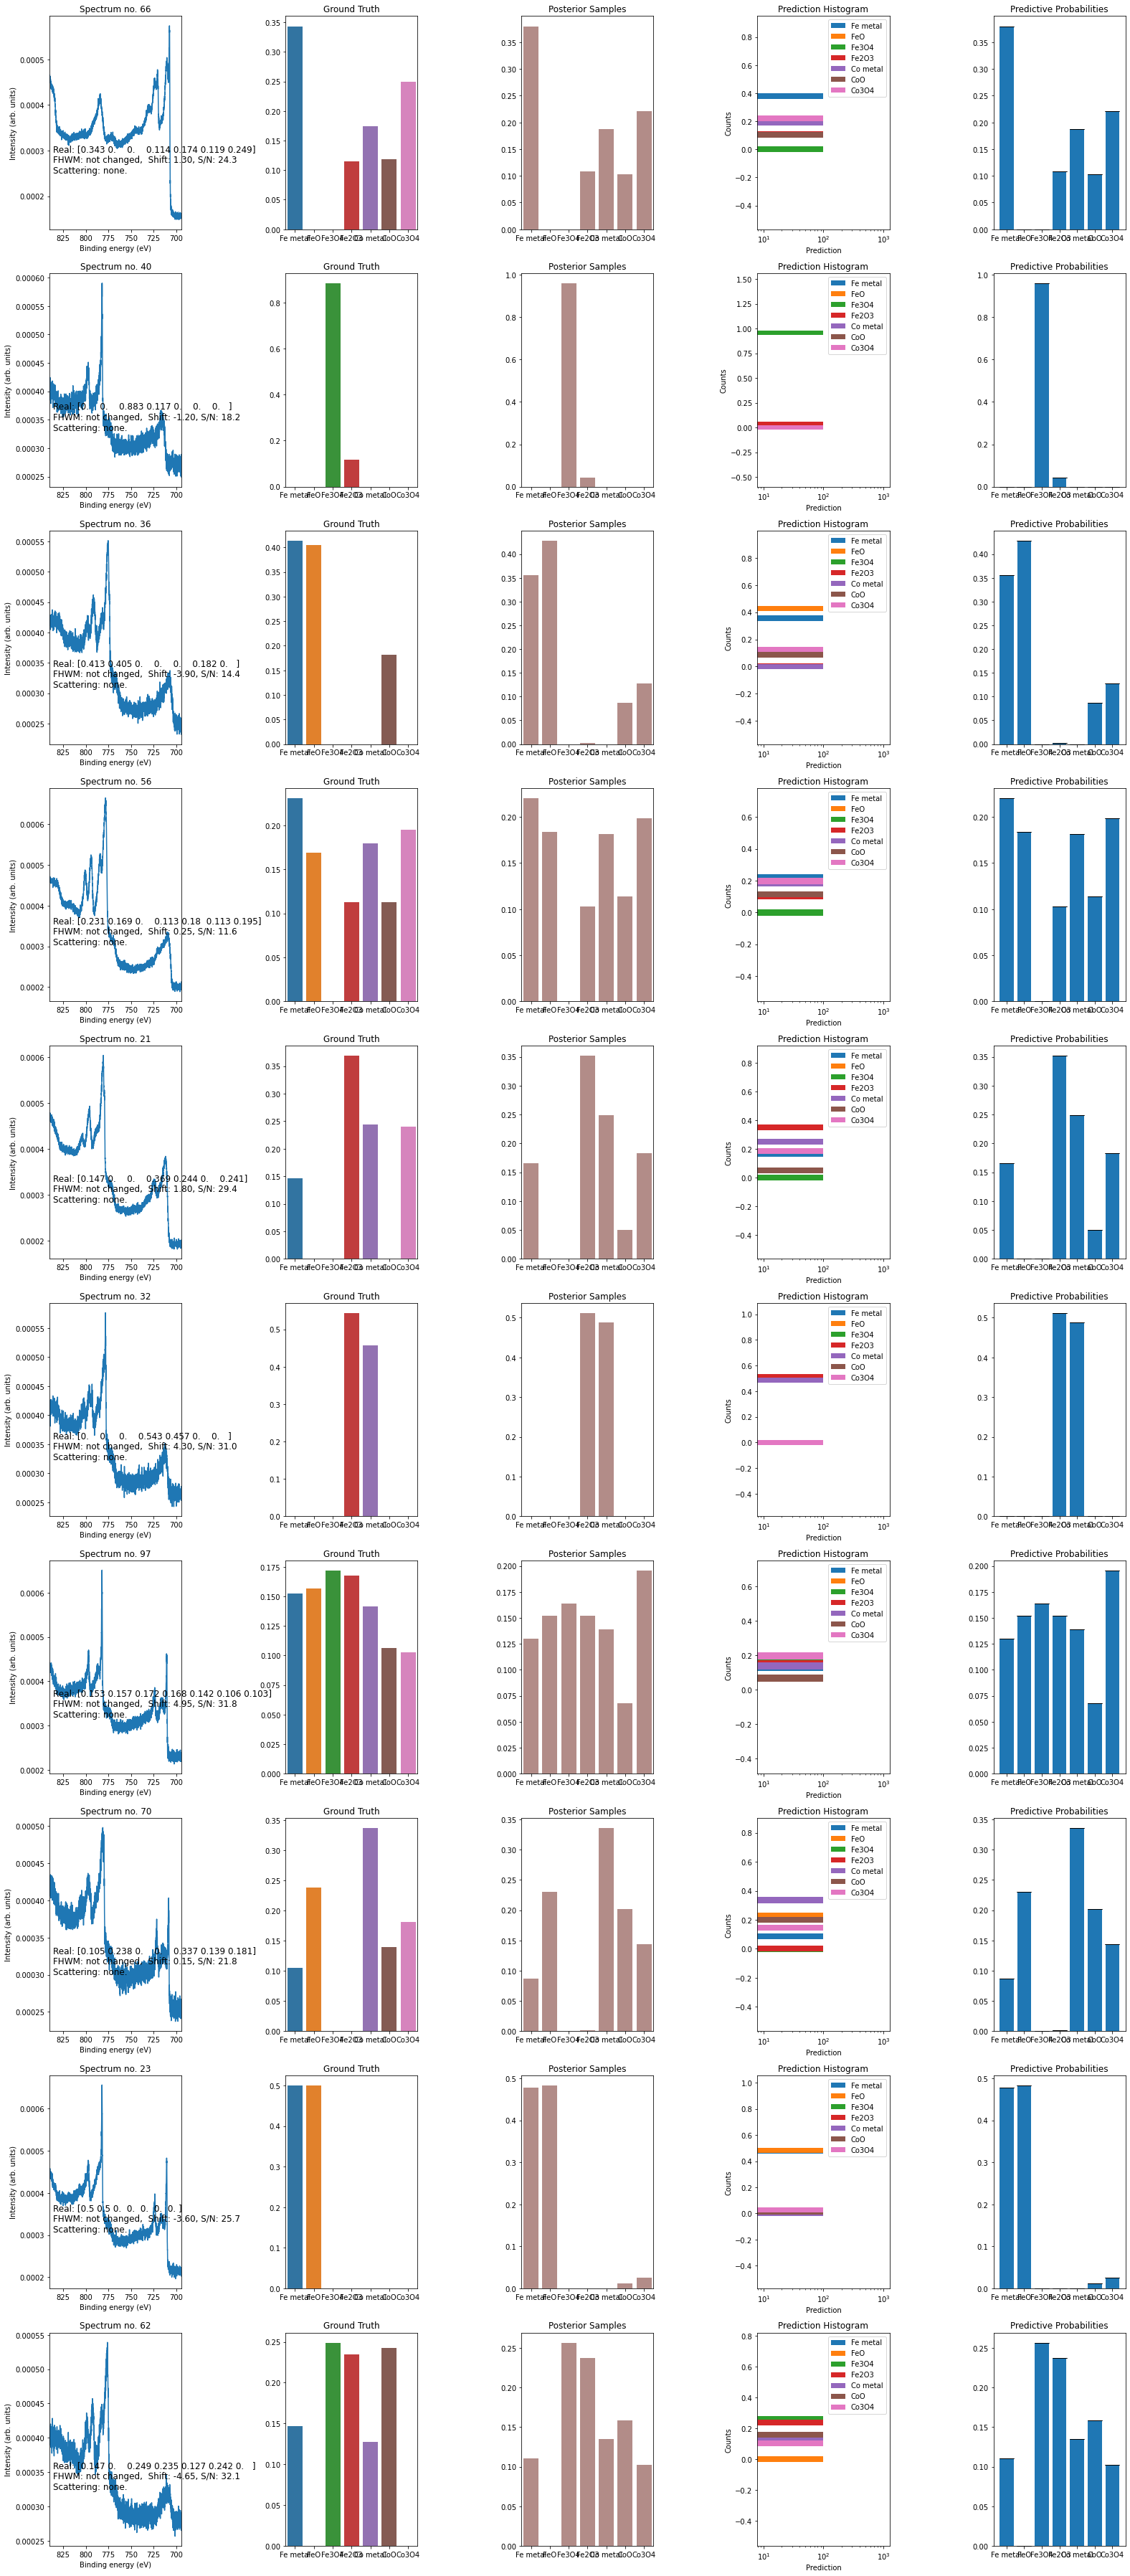

In [ ]:
prob_preds = clf.predict_probabilistic(dataset="test", no_of_predictions=200)
clf.plot_prob_predictions(dataset="test", no_of_spectra=10, to_file=False)

In [ ]:
pip install xlsxwriter

     |████████████████████████████████| 148 kB 9.4 MB/s 


(200, 7) (200, 7)


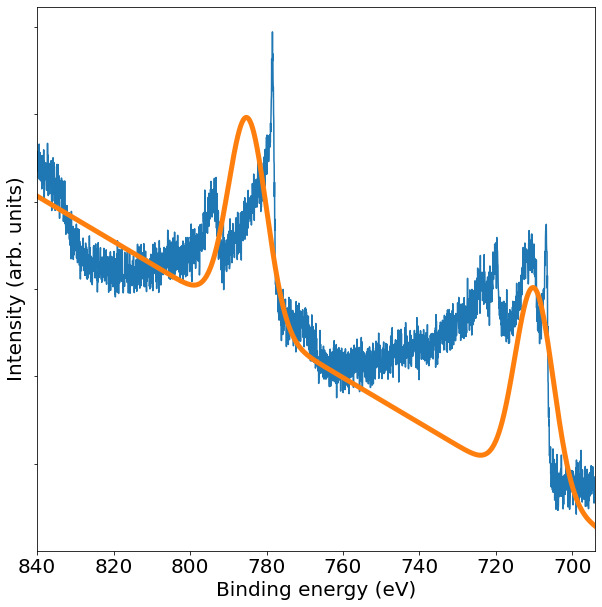

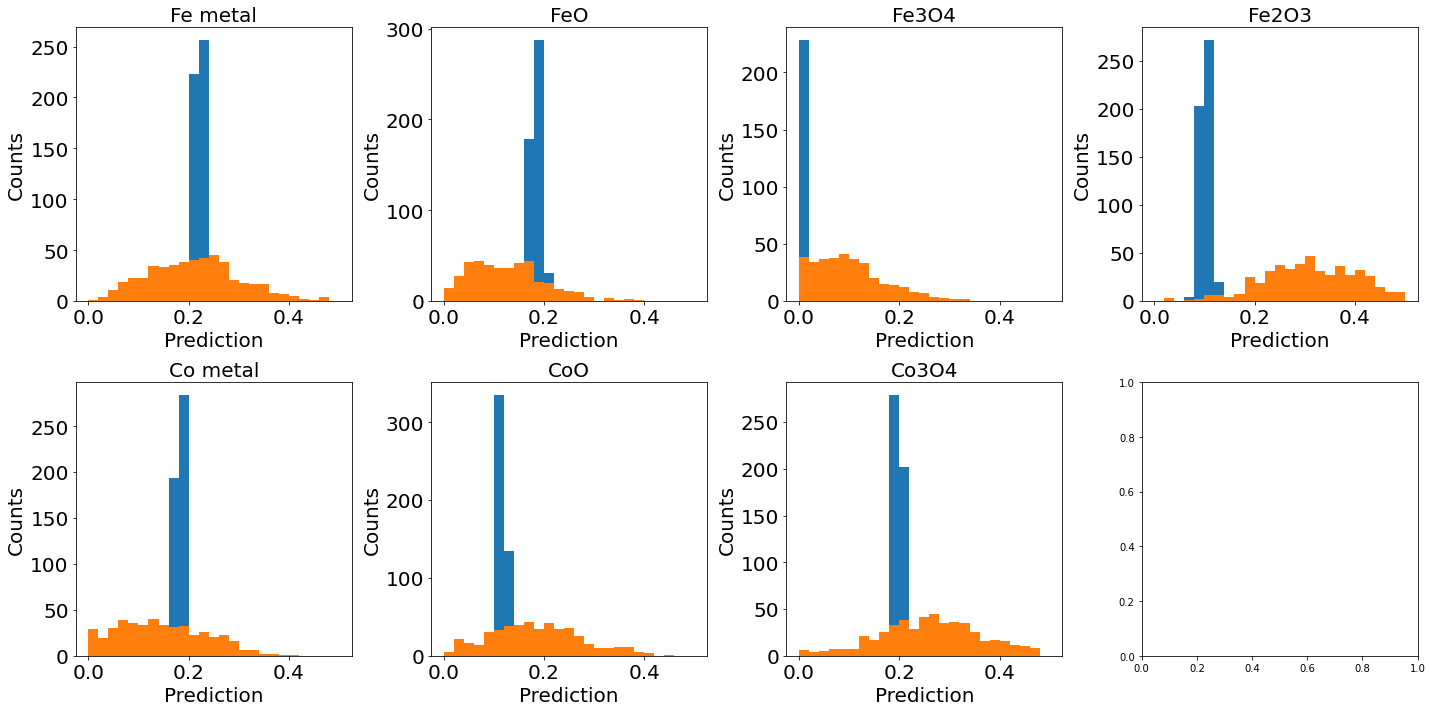

In [ ]:
from xpsdeeplearning.simulation.base_model.spectra import SyntheticSpectrum
from xpsdeeplearning.simulation.base_model.peaks import Gauss

#loc – (average) where the top of the bell is located.
#Scale – (standard deviation) how uniform you want the graph to be distributed.
#size – Shape of the returning Array

def broaden(x,intensity,resolution):
    fwhm = np.mean(x) / float(resolution)
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))

    intensity = intensity.reshape((intensity.shape[0],))
    # To preserve the position of spectral lines, the
    # broadening function must be centered at
    # N//2 - (1-N%2) = N//2 + N%2 - 1.
    len_x = len(x)
    step = 0.1#self.step
    gauss_x = (
        np.arange(len_x, dtype=np.int) - sum(divmod(len_x, 2)) + 1
    ) * step

    # The broadening spectrum is a synthetic spectrum.
    broadening_spectrum = SyntheticSpectrum(
        gauss_x[0], gauss_x[-1], step, label="Gauss"
    )
    broadening_spectrum.add_component(
        Gauss(position=0, width=sigma, intensity=1)
    )

    # This assures that the edges are handled correctly.
    len_y = len(intensity)
    y = np.concatenate(
        (
            np.ones(len_y) * intensity[0],
            intensity,
            np.ones(len_y) * intensity[-1],
        )
    )

    # This performs the convolution of the initial lineshape
    # with the Gaussian kernel.
    # Note: The convolution is performed in the Fourier space.
    from scipy.signal import fftconvolve
    result = fftconvolve(
        y, broadening_spectrum.lineshape, mode="same"
    )
    result = result[len_y:-len_y]
    result /= sum(result)
    return result.reshape((result.shape[0],1))

def add_synthetic_spectrum(energies, X_real):
    syn_spectrum = SyntheticSpectrum(
        clf.datahandler.energies[-1],
        clf.datahandler.energies[0], 
        step=0.05, label="Gauss"
    )
    syn_spectrum.add_component(
        Gauss(position=710, width=5, intensity=0.001)
        )
    syn_spectrum.add_component(
        Gauss(position=785, width=5, intensity=0.001)
        )
    syn_spectrum.lineshape += np.min(X_real)
    syn_spectrum.normalize()
    slope = float((X_real[0] - X_real[-1]) / (energies[0] - energies[-1]))
    intercept = X_real[0] - slope*energies[0]
    line = np.array([(slope*x + intercept) for x in energies])
    syn_spectrum.lineshape = np.expand_dims(syn_spectrum.lineshape, axis=1)
    syn_spectrum.lineshape = np.add(syn_spectrum.lineshape, line)
    syn_spectrum.lineshape -= np.average(X_real)

    return syn_spectrum.lineshape

def plot_spectra(self, index):
    energies = self.datahandler.energies
    X_real = self.datahandler.X_test[index]
    y_real = self.datahandler.y_test[index:index+1]

    X_new = add_synthetic_spectrum(energies, X_real)

    fig, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(10,10)
    )
    colors = iter(["blue","orange"])
    color = next(colors)
    ax.plot(energies, X_real)
    ax.plot(energies, X_new, linewidth=5)
    ax.invert_xaxis()
    ax.set_xlim(np.max(energies), np.min(energies))

    fontdict = {"size": 20}
    ax.set_xlabel("Binding energy (eV)",
                   fontdict=fontdict)
    ax.set_ylabel("Intensity (arb. units)", 
                   fontdict=fontdict)
    ax.tick_params(axis="x", labelsize=fontdict["size"])
    ax.set_yticklabels([])
    #ax.legend(["in-scope", "out-of-scope"],prop={"size": fontdict["size"]})

    return fig
   
def plot_prob_predictions(self, prob_preds_real, prob_preds_fake):
    energies = self.datahandler.energies
    X_real = self.datahandler.X_test[index]
    y_real = self.datahandler.y_test[index:index+1]
    prob_preds_real = prob_preds_real[index, :, :]
    prob_preds_fake = prob_preds_fake[0,:,:]

    print(prob_preds_real.shape,prob_preds_fake.shape)
   
    normal_real =  np.random.normal(loc=0.5,
                                    scale=0.5,
                                    size=7)
    
    normal_fake = np.random.normal(loc=0.5,
                                   scale=0.5,
                                   size=7)
      
    prod_preds_real_with_normal = 0
    fontdict = {"size": 20}
    fontdict_small = {"size": 20}
    fontdict_extra_small = {"size": 20}
    fig, axs = plt.subplots(
        nrows=2, ncols=4, figsize=(20,10)
    )

    for j, row in enumerate(prob_preds_real.transpose()):
        row = np.random.normal(np.mean(row),scale=0.01,size=500)
        if j < 4:
           row_no = 0
           col_no = j
        else:
           row_no = 1
           col_no = j-4
        _ = axs[row_no,col_no].hist(
            row,
            bins=25,
            range=(0.,.5),
            orientation="vertical",
            fill=True,
            linewidth=1,
            label=self.datahandler.labels[j],
        )
    for j, row in enumerate(prob_preds_fake.transpose()):
        row = np.random.normal(np.mean(row),scale=0.1,size=500)
        if j < 4:
           row_no = 0
           col_no = j
        else:
           row_no = 1
           col_no = j-4
        _ = axs[row_no,col_no].hist(
            row,
            bins=25,
            range=(0.,.5),
            orientation="vertical",
            fill=True,
            linewidth=1,
            label=self.datahandler.labels[j],
        )    
    axs[0,0].set_title("Fe metal",fontdict=fontdict)
    axs[0,1].set_title("FeO",fontdict=fontdict)
    axs[0,2].set_title("Fe3O4",fontdict=fontdict)
    axs[0,3].set_title("Fe2O3",fontdict=fontdict)
    axs[1,0].set_title("Co metal",fontdict=fontdict)
    axs[1,1].set_title("CoO",fontdict=fontdict)
    axs[1,2].set_title("Co3O4",fontdict=fontdict)

    axs[0,0].set_xlabel("Prediction",fontdict=fontdict_small)
    axs[0,1].set_xlabel("Prediction",fontdict=fontdict_small)
    axs[0,2].set_xlabel("Prediction",fontdict=fontdict_small)
    axs[0,3].set_xlabel("Prediction",fontdict=fontdict_small)
    axs[1,0].set_xlabel("Prediction",fontdict=fontdict_small)
    axs[1,1].set_xlabel("Prediction",fontdict=fontdict_small)
    axs[1,2].set_xlabel("Prediction",fontdict=fontdict_small)

    axs[0,0].set_ylabel("Counts",fontdict=fontdict_small)
    axs[0,1].set_ylabel("Counts",fontdict=fontdict_small)
    axs[0,2].set_ylabel("Counts",fontdict=fontdict_small)
    axs[0,3].set_ylabel("Counts",fontdict=fontdict_small)
    axs[1,0].set_ylabel("Counts",fontdict=fontdict_small)
    axs[1,1].set_ylabel("Counts",fontdict=fontdict_small)
    axs[1,2].set_ylabel("Counts",fontdict=fontdict_small)

    axs[0,0].tick_params(axis="x", labelsize=fontdict_extra_small["size"])
    axs[0,1].tick_params(axis="x", labelsize=fontdict_extra_small["size"])
    axs[0,2].tick_params(axis="x", labelsize=fontdict_extra_small["size"])
    axs[0,3].tick_params(axis="x", labelsize=fontdict_extra_small["size"])
    axs[1,0].tick_params(axis="x", labelsize=fontdict_extra_small["size"])
    axs[1,1].tick_params(axis="x", labelsize=fontdict_extra_small["size"])
    axs[1,2].tick_params(axis="x", labelsize=fontdict_extra_small["size"])

    axs[0,0].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
    axs[0,1].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
    axs[0,2].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
    axs[0,3].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
    axs[1,0].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
    axs[1,1].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
    axs[1,2].tick_params(axis="y", labelsize=fontdict_extra_small["size"])
          
    fig.tight_layout()

    return X_new# fig

    
index = 56
fig1 = plot_spectra(clf, index)

X_new = plot_prob_predictions(clf, prob_preds_real, prob_preds_fake)

[[0.23059266 0.16859037 0.         0.11258852 0.17994385 0.11293073
  0.19535387]] [[2.20041543e-01 1.83619276e-01 2.37365693e-05 1.02689497e-01
  1.81421727e-01 1.13788165e-01 1.98416069e-01]]


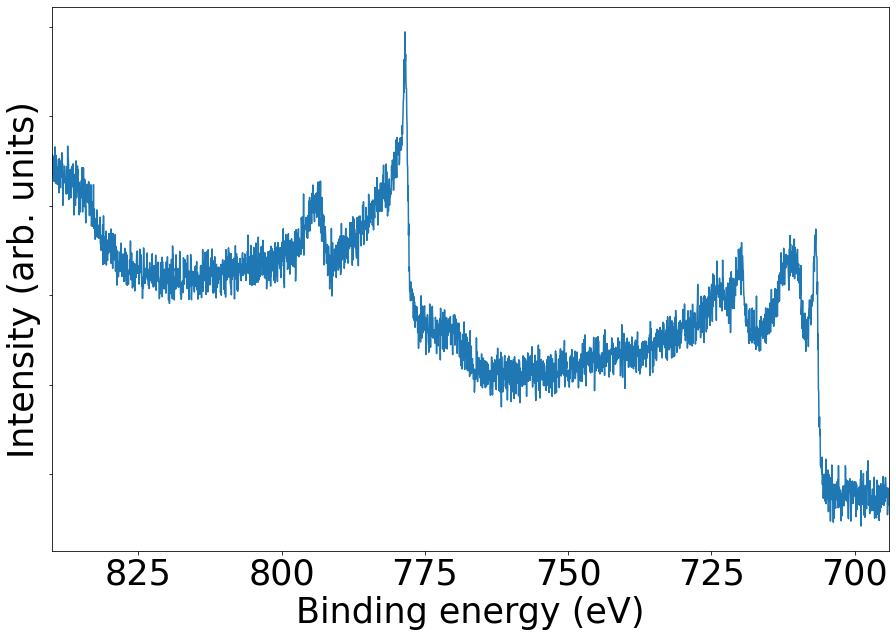

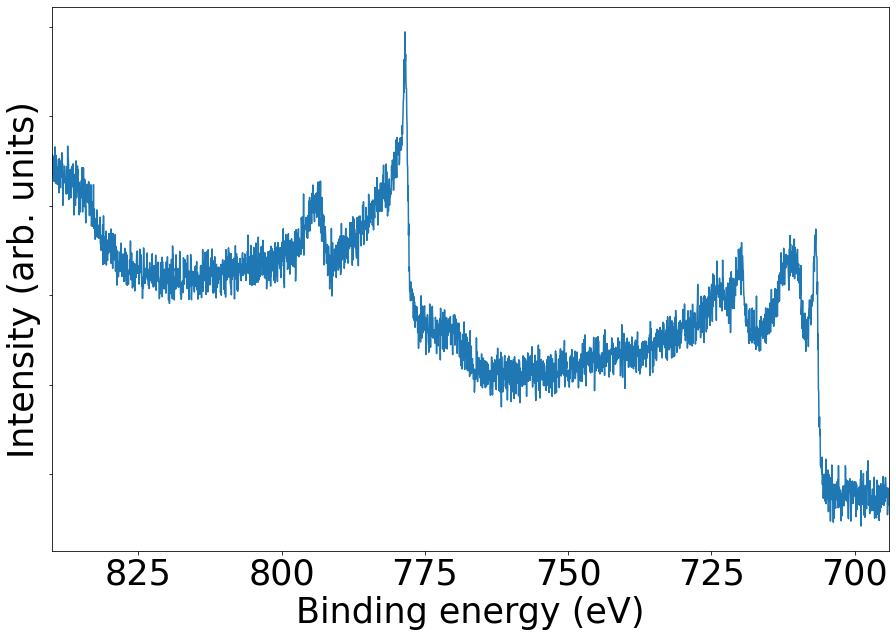

In [ ]:
def plot_spectra(self, index):
    energies = self.datahandler.energies
    X_real = self.datahandler.X_test[index]
    y_real = self.datahandler.y_test[index:index+1]
    pred = self.datahandler.pred_test[index:index+1]
    print(y_real, pred)
    fig, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(15,10)
    )
    colors = iter(["blue","orange"])
    color = next(colors)
    ax.plot(energies, X_real)
    ax.invert_xaxis()
    ax.set_xlim(np.max(energies), np.min(energies))

    fontdict = {"size": 35}
    ax.set_xlabel("Binding energy (eV)",
                   fontdict=fontdict)
    ax.set_ylabel("Intensity (arb. units)", 
                   fontdict=fontdict)
    ax.tick_params(axis="x", labelsize=fontdict["size"])
    ax.set_yticklabels([])
    #ax.legend(["in-scope", "out-of-scope"],prop={"size": fontdict["size"]})

    return fig

plot_spectra(clf, index= 56)

In [ ]:
clf.datahandler.X_train = np.expand_dims(X_new, axis =0)
prob_preds_fake = np.expand_dims(np.tile([0.2,0.1,0.05,0.32,0.13,0.18,0.26], (200, 1)), axis = 0)#clf.predict_probabilistic(dataset="train", no_of_predictions=200)
prob_preds_real = clf.predict_probabilistic(dataset="test", no_of_predictions=200)
clf.plot_prob_predictions(dataset="test", no_of_spectra=10, to_file=False)